In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df_original = pd.read_csv('../data/FultonPUMS5full.csv')
df = df_original

In [5]:
df.sample(10)

,state,puma,sex,age,educ,income,latino,black,asian,married,divorced,uscitizen,children,disability,militaryservice,employed,englishability,fips
21427,13,1106,1,53,9,315000.0,0,1,0,0,0,1,0,0,0,0,1,13121
14500,13,1104,1,79,8,4500.0,0,0,0,1,0,1,0,0,0,0,1,13121
8674,13,1102,0,24,10,26000.0,0,0,0,0,0,1,0,0,1,0,1,13121
20551,13,1106,1,25,9,26000.0,0,1,0,0,0,1,0,0,0,0,1,13121
14211,13,1104,0,38,6,70000.0,0,0,0,0,1,1,0,0,0,1,1,13121
19894,13,1106,1,74,9,3700.0,0,1,0,1,0,1,0,1,0,0,1,13121
8679,13,1102,0,18,8,5600.0,0,0,0,0,0,1,0,0,0,0,1,13121
24442,13,1107,1,68,2,0.0,0,1,0,1,0,1,0,0,0,0,1,13121
20697,13,1106,0,18,4,0.0,0,1,0,0,0,1,0,0,0,0,1,13121
21236,13,1106,0,60,7,11900.0,0,1,0,1,0,1,0,0,0,1,1,13121


Problem 1:

We need to find some subset of attributes such that their conjunction uniquely specifies an individual out of 100,000 other individuals in the same PUMA region.

In [6]:
attributes = ['age', 'income']
print("Using attributes {}".format(attributes))
for puma_index in df['puma'].unique():
    df_subset = df[df['puma'] == puma_index]
    attr_hash = np.apply_along_axis(
        func1d=lambda vec: hash('_'.join(vec.astype('str').tolist())), # hash the items
        axis=1, # in each row
        arr=df_subset[attributes].values, # matrix of relevant values
    )
    _, unique_counts = np.unique(attr_hash, return_counts=True)
    unique_individuals = unique_counts == 1
    uniquely_identified_ratio = unique_individuals.shape[0]/df_subset.shape[0]
    print("For PUMA block {},"
          " uniquely identified {:0.1f}% of individuals from a sample size of {}".format(
        puma_index, uniquely_identified_ratio*100, df_subset.shape[0]
    ))

Using attributes ['age', 'income']
For PUMA block 1101, uniquely identified 78.9% of individuals from a sample size of 3215
For PUMA block 1102, uniquely identified 72.9% of individuals from a sample size of 5736
For PUMA block 1103, uniquely identified 77.5% of individuals from a sample size of 3728
For PUMA block 1104, uniquely identified 68.4% of individuals from a sample size of 3740
For PUMA block 1105, uniquely identified 74.1% of individuals from a sample size of 3128
For PUMA block 1106, uniquely identified 76.7% of individuals from a sample size of 3236
For PUMA block 1107, uniquely identified 79.8% of individuals from a sample size of 2983


We can see that we can uniquely identify 90% of the individuals in a ~5% sample of each census block using only the 'age', 'education', and 'income' features.

However, we need to argue that even with 20x as many individuals, a sizable portion would still be uniquely identifiable.

So now, we'll make a less empirical approximation, namely that some subset of the columns are independent, and therefore that in the wider sample we'd get random samples from them.

In [7]:
attr_counts = {col:df[col].unique().shape[0] for col in df.columns if col not in ['age', 'income']}
attrs_sorted = sorted(attr_counts.keys(), key=lambda x: attr_counts[x])
necessary_attrs = []
from operator import mul
while np.prod([1] + [attr_counts[a] for a in necessary_attrs]) < 100_000:
    print(np.prod([1] + [attr_counts[a] for a in necessary_attrs]))
    necessary_attrs.append(attrs_sorted.pop()) 
print(necessary_attrs)
print("unused: {}".format(attrs_sorted))

1
16
112
224
448
896
1792
3584
7168
14336
28672
57344
['educ', 'puma', 'englishability', 'employed', 'militaryservice', 'disability', 'children', 'uscitizen', 'divorced', 'married', 'asian', 'black']
unused: ['state', 'fips', 'sex', 'latino']


In [8]:
attributes = list(set(df.columns) - set(['puma', 'income', 'age']))
print("Using attributes {}".format(attributes))
for puma_index in df['puma'].unique():
    df_subset = df[df['puma'] == puma_index]
    attr_hash = np.apply_along_axis(
        func1d=lambda vec: hash('_'.join(vec.astype('str').tolist())), # hash the items
        axis=1, # in each row
        arr=df_subset[attributes].values, # matrix of relevant values
    )
    _, unique_counts = np.unique(attr_hash, return_counts=True)
    unique_individuals = unique_counts == 1
    uniquely_identified_ratio = unique_individuals.shape[0]/df_subset.shape[0]
    print("For PUMA block {},"
          " uniquely identified {:0.1f}% of individuals from a sample size of {}".format(
        puma_index, uniquely_identified_ratio*100, df_subset.shape[0]
    ))

Using attributes ['englishability', 'latino', 'disability', 'employed', 'children', 'sex', 'black', 'divorced', 'married', 'state', 'educ', 'asian', 'militaryservice', 'uscitizen', 'fips']
For PUMA block 1101, uniquely identified 19.6% of individuals from a sample size of 3215
For PUMA block 1102, uniquely identified 20.8% of individuals from a sample size of 5736
For PUMA block 1103, uniquely identified 24.4% of individuals from a sample size of 3728
For PUMA block 1104, uniquely identified 27.2% of individuals from a sample size of 3740
For PUMA block 1105, uniquely identified 33.0% of individuals from a sample size of 3128
For PUMA block 1106, uniquely identified 21.7% of individuals from a sample size of 3236
For PUMA block 1107, uniquely identified 27.6% of individuals from a sample size of 2983


## PART 1 ISN'T DONE

Problem 2

In [9]:
df = pd.read_csv('../data/FultonPUMS5sample100.csv')

In [10]:
df.sample(10)

,state,puma,sex,age,educ,income,latino,black,asian,married,divorced,uscitizen,children,disability,militaryservice,employed,englishability,fips
31,13,1106,0,80,4,24800,0,1,0,1,0,1,0,1,1,0,1,13121
3,13,1105,0,22,1,6800,1,0,0,1,0,1,0,0,0,0,1,13121
7,13,1106,0,19,7,0,0,1,0,0,0,1,0,0,0,1,1,13121
55,13,1104,1,53,4,7900,0,1,0,0,1,1,1,1,0,0,1,13121
81,13,1107,0,19,6,0,0,1,0,0,0,1,0,0,0,0,1,13121
52,13,1102,0,52,6,60000,0,0,0,0,1,1,0,1,0,1,1,13121
35,13,1104,1,30,12,24000,0,1,0,0,0,1,0,0,0,1,1,13121
90,13,1106,0,46,9,23000,0,1,0,1,0,1,0,0,0,1,1,13121
72,13,1104,0,22,9,20000,0,1,0,0,1,1,0,0,0,1,1,13121
38,13,1105,1,20,10,6500,0,1,0,0,0,1,0,1,0,1,1,13121


In [9]:
uscit = df['uscitizen']
df = df.drop(columns=['uscitizen'])

In [10]:
n = df.shape[0]
# we'll do a little work upfront to make hashing faster
df_stringified = np.array([''.join(row.values.astype('str')) for _, row in df.iterrows()])
def create_predicate_fn():
    hash_key = str(np.random.randint(10**10))
    return lambda x_stringified: hash(x_stringified + hash_key) % 2 == 0
    
def query(n_subsamples=False, rounding_R=False, noise_sigma=False):
    f = create_predicate_fn()
    included_inds = [f(row_str) for row_str in df_stringified]
    supposedly_included_inds = included_inds
    
    if n_subsamples: # compute using only a subset of the data
        good_inds = np.random.choice(range(n), n_subsamples, replace=False)
        included_in_subsample = np.zeros(n)
        included_in_subsample[good_inds] += 1
        included_inds *= included_in_subsample
    
    s = sum(uscit*included_inds) # compute the actual query
    
    if rounding_R: # round to the nearest multiple of R
        s = rounding_R*round(s/rounding_R)
    if noise_sigma: # add Gaussian noise with stdev noise_sigma
        s += np.random.normal(loc=0, scale=noise_sigma)
    if n_subsamples:
        s *= n/n_subsamples# scale back up
    return s, supposedly_included_inds

In [11]:
query_vector = [query() for _ in range(n)]
answers, indices = zip(*query_vector)

Now let's create the attack

In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False).fit(indices, answers)
estimated_uscit = lr.coef_

In [13]:
np.linalg.norm(estimated_uscit - uscit, ord=2)

2.498289336621914e-13

Let's demonstrate the effect of different secrecy mechanisms on our reconstruction attack.

Note that we'll assume that we will binarize our inferred attributes by rounding "uscitizen" to 0 or 1, even though our regression gives us out a continuous value.

In [14]:
def run_reconstruction_experiment(varied_param, n_trials_per=10, value_range=np.arange(1, n)):
    assert varied_param in ["n_subsamples", "rounding_R", "noise_sigma"]
    value_range = np.array(value_range)
    avg_mse = np.zeros(value_range.shape[0])
    avg_pct_correct = np.zeros(value_range.shape[0])

    from tqdm import tqdm
    for i, value in tqdm(enumerate(value_range), total=value_range.shape[0]):
        agg_mse = 0
        agg_pct_correct = 0
        for _ in range(n_trials_per):
            answers, indices = zip(*[query(
                **{varied_param:value}
            ) for _ in range(2*n)])
            estimated_uscit_raw = LinearRegression(fit_intercept=False).fit(indices, answers).coef_
            mse = np.linalg.norm(estimated_uscit_raw - uscit, ord=2)
            agg_mse += mse
            estimated_uscit = np.round(estimated_uscit_raw)
            agg_pct_correct += (uscit==estimated_uscit).mean()
        avg_mse[i] = agg_mse/n_trials_per
        avg_pct_correct[i] = agg_pct_correct/n_trials_per
    return avg_mse, avg_pct_correct

In [15]:
avg_mse_subsampling, avg_pc_subsampling = run_reconstruction_experiment(varied_param="n_subsamples")

  3%|▎         | 3/99 [00:02<01:27,  1.09it/s]


KeyboardInterrupt: 

In [121]:
avg_mse_subsampling_focused, avg_pc_subsampling_focused = run_reconstruction_experiment(
    varied_param="n_subsamples",
    value_range=np.arange(50, 80),
    n_trials_per=20
)

100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


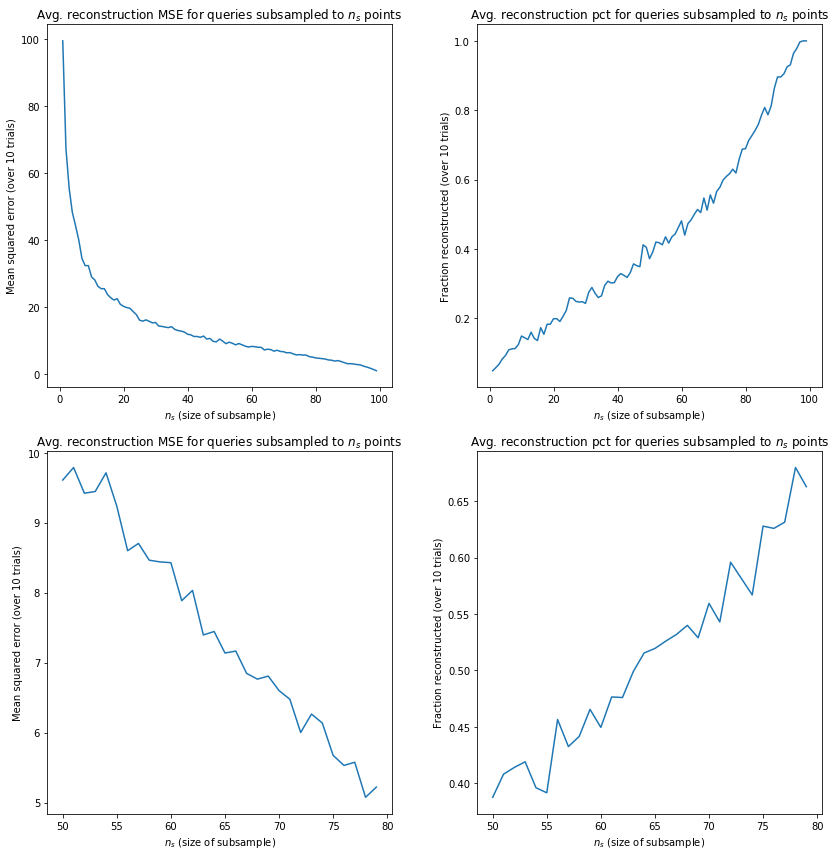

In [122]:
original_range = np.arange(1, n)
narrowed_range_subsampling = np.arange(50, 80)
plt.subplots(2, 2, figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_subsampling)
plt.title("Avg. reconstruction MSE for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_subsampling)
plt.title("Avg. reconstruction pct for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_subsampling, avg_mse_subsampling_focused)
plt.title("Avg. reconstruction MSE for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_subsampling, avg_pc_subsampling_focused)
plt.title("Avg. reconstruction pct for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

It seems like reconstruction accuracy drops below 50% when using a subsample of less than 64 datapoints.

In [16]:
avg_mse_rounding,avg_pc_rounding = run_reconstruction_experiment(varied_param="rounding_R")

100%|██████████| 99/99 [01:20<00:00,  1.23it/s]


In [19]:
narrowed_range_rounding = np.arange(10, 20)
avg_mse_rounding_narrowed, avg_pc_rounding_narrowed = run_reconstruction_experiment(
    varied_param="rounding_R",
    value_range=narrowed_range_rounding,
    n_trials_per=20
)

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


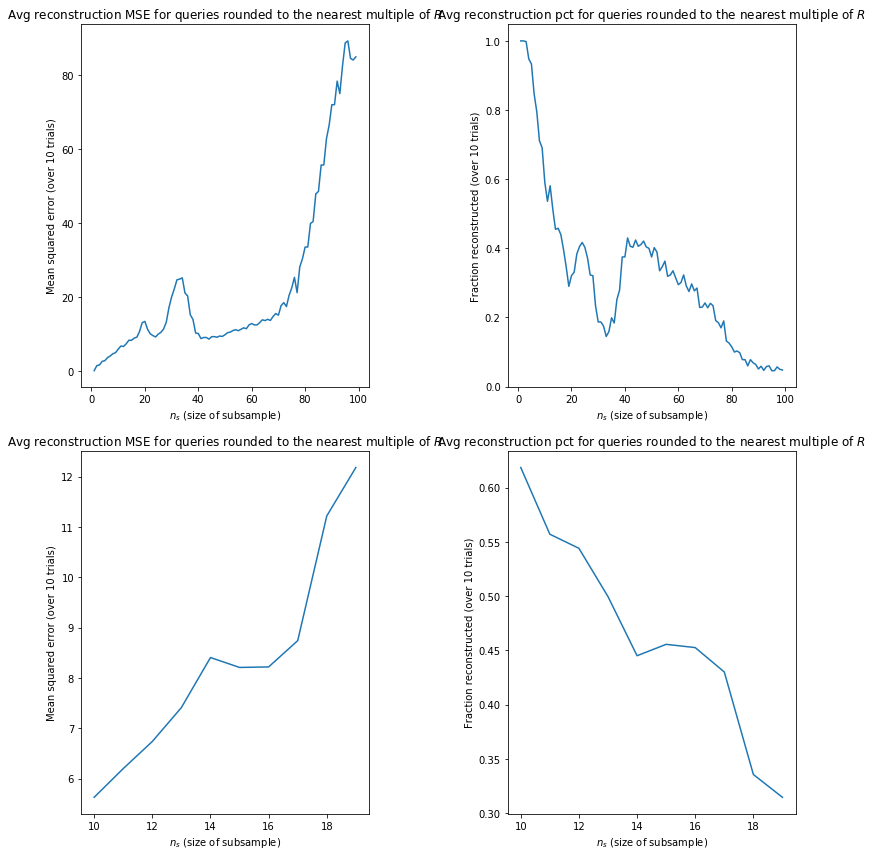

In [20]:
original_range = np.arange(1, n)
plt.subplots(2, 2, figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_rounding)
plt.title("Avg reconstruction MSE for queries rounded to the nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_rounding)
plt.title("Avg reconstruction pct for queries rounded to the nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_rounding, avg_mse_rounding_narrowed)
plt.title("Avg reconstruction MSE for queries rounded to the nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_rounding, avg_pc_rounding_narrowed)
plt.title("Avg reconstruction pct for queries rounded to the nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

Rounding up to multiples of 12 seems to be the maximum tolerance for still reconstructing 50% of the data.

In [25]:
avg_mse_noise,avg_pc_noise = run_reconstruction_experiment(varied_param="noise_sigma")

100%|██████████| 99/99 [01:24<00:00,  1.18it/s]


In [29]:
narrowed_range_noise = np.linspace(0, 10, 50)
avg_mse_noise_narrowed, avg_pc_noise_narrowed = run_reconstruction_experiment(
    varied_param="noise_sigma",
    value_range=narrowed_range_noise,
    n_trials_per=20
)

100%|██████████| 50/50 [01:19<00:00,  1.55s/it]


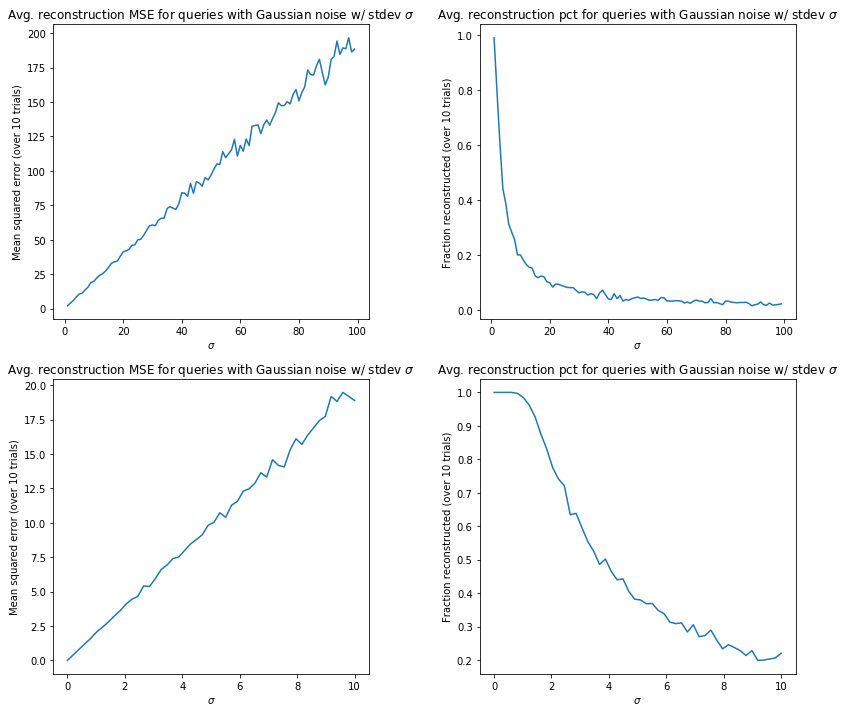

In [33]:
plt.subplots(2, 2, figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_noise)
plt.title("Avg. reconstruction MSE for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_noise)
plt.title("Avg. reconstruction pct for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_noise, avg_mse_noise_narrowed)
plt.title("Avg. reconstruction MSE for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_noise, avg_pc_noise_narrowed)
plt.title("Avg. reconstruction pct for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

Reconstruction drops below 50% when injected Gaussian noise grows above $\sigma=4$.

Problem 3

In [95]:
df = df_original
df_stringified = np.array([''.join(row.values.astype('str')) for _, row in df.iterrows()])

max_constructed_features = 100
new_predicate_fns = [create_predicate_fn() for _ in range(max_constructed_features)]
df_expanded = df.copy()
for i, f in enumerate(new_predicate_fns):
    df_expanded['np_{:03d}'.format(i)] = pd.Series([int(f(x)) for x in df_stringified])

In [96]:
df_expanded

,state,puma,sex,age,educ,income,latino,black,asian,married,...,np_090,np_091,np_092,np_093,np_094,np_095,np_096,np_097,np_098,np_099
0,13,1101,1,51,11,2200.0,0,0,0,1,...,1,1,0,1,0,1,0,1,1,1
1,13,1101,0,44,11,125030.0,0,0,0,1,...,0,1,1,0,0,1,1,1,1,0
2,13,1101,0,60,11,105000.0,0,0,0,1,...,0,1,0,0,1,1,0,1,1,1
3,13,1101,0,41,13,52000.0,0,0,0,0,...,0,0,1,1,0,1,1,1,1,1
4,13,1101,0,56,13,263000.0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
5,13,1101,0,42,14,100000.0,0,0,0,1,...,1,1,1,1,0,0,0,0,0,1
6,13,1101,0,45,13,26000.0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,1
7,13,1101,0,53,11,65200.0,0,0,0,1,...,0,0,1,1,1,1,1,0,1,0
8,13,1101,0,40,13,98030.0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,1
9,13,1101,1,28,14,26000.0,0,0,0,1,...,1,1,0,1,0,0,1,1,1,1
